# 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daily-bike-share/bike_sharing_daily (1).csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel , TFTModel
from darts.metrics import mape
from darts.timeseries import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from sklearn.model_selection import ParameterGrid
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf,month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
df = pd.read_csv("/kaggle/input/daily-bike-share/bike_sharing_daily (1).csv")
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [5]:
df.rename(columns = {'dteday':'ds',
                    'cnt' : 'y'}, inplace = True)

In [6]:
df.shape

(731, 16)

In [7]:
df.columns

Index(['instant', 'ds', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'y'],
      dtype='object')

In [8]:
df.drop(['yr','mnth','instant',
        'casual', 'registered'], axis = 1, inplace = True)

In [9]:
df['ds'] = pd.to_datetime(df['ds'])

In [10]:
df.set_index('ds', inplace = True)

In [11]:
df = df.asfreq('D')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2011-01-01 to 2012-12-31
Freq: D
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      731 non-null    int64  
 1   holiday     731 non-null    int64  
 2   weekday     731 non-null    int64  
 3   workingday  731 non-null    int64  
 4   weathersit  731 non-null    int64  
 5   temp        731 non-null    float64
 6   atemp       731 non-null    float64
 7   hum         731 non-null    float64
 8   windspeed   731 non-null    float64
 9   y           731 non-null    int64  
dtypes: float64(4), int64(6)
memory usage: 62.8 KB


# EDA

<Axes: xlabel='ds'>

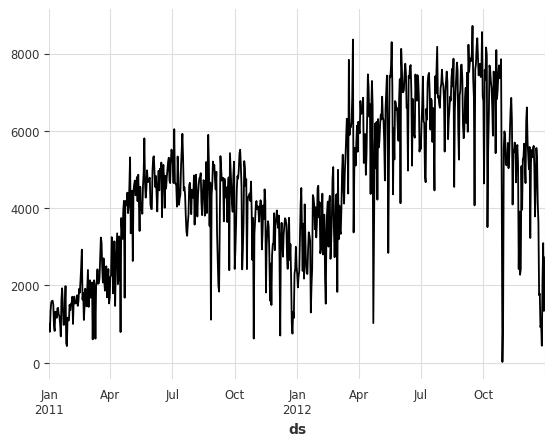

In [13]:
df['y'].plot()

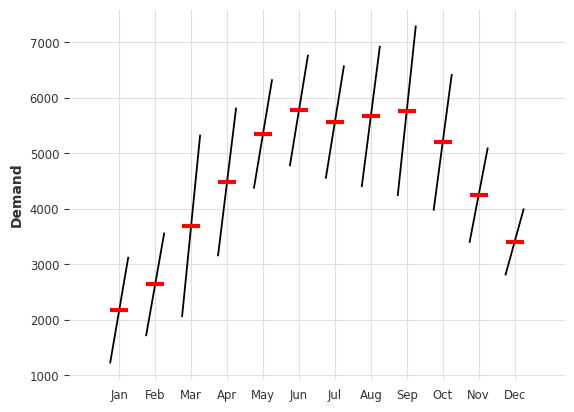

In [14]:
month_plot(df['y'].resample("ME").mean() , ylabel = "Demand")
plt.show()

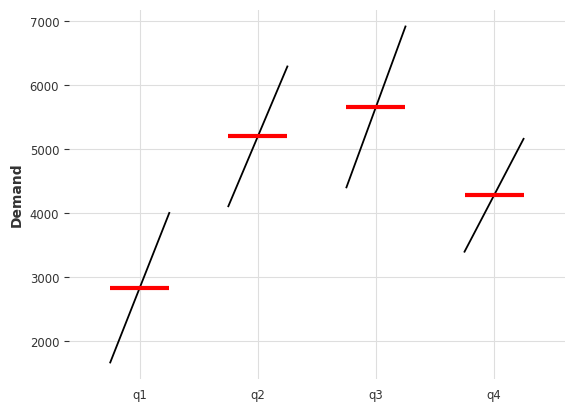

In [15]:
quarter_plot(df['y'].resample('QE').mean(), ylabel = 'Demand')
plt.show()

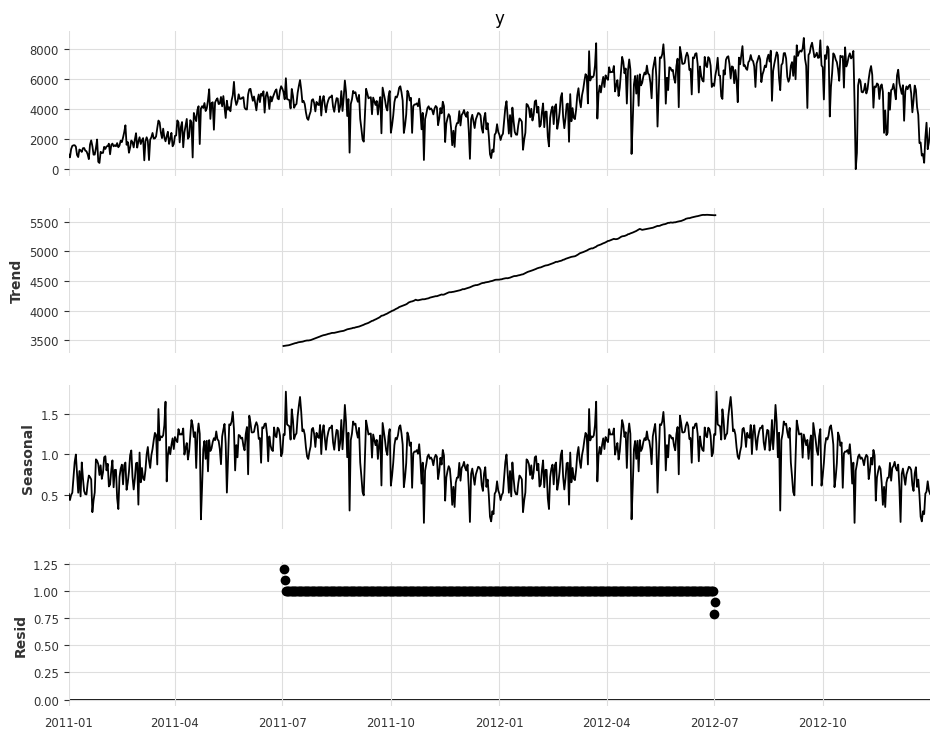

In [16]:
decomposition = seasonal_decompose(df['y'] , model = 'mul' , period = 365)
fig = decomposition.plot()
fig.set_size_inches(10,8)
fig.show()

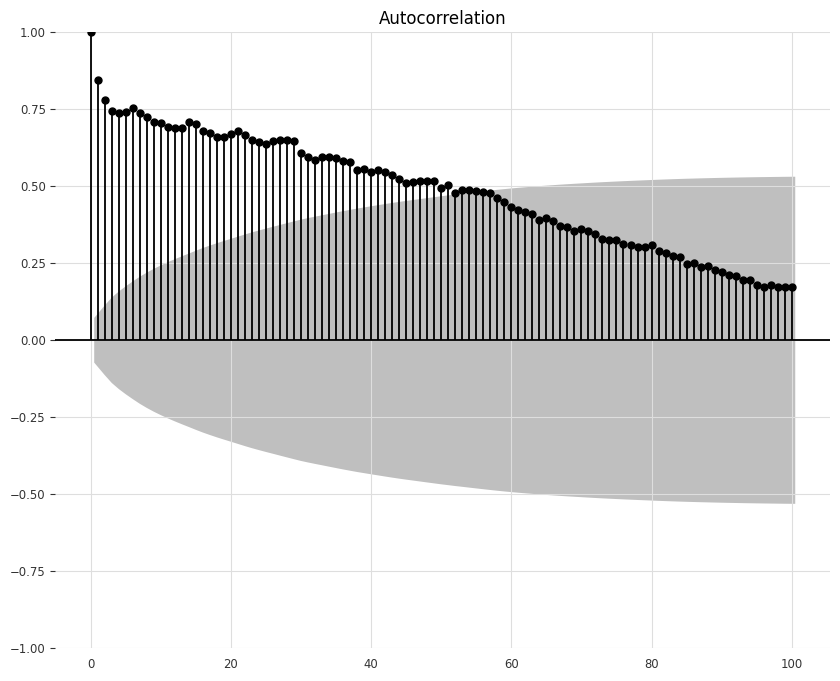

In [17]:
plt.rc("figure" ,figsize = (10,8))
plot_acf(df['y'] , lags = 100)
plt.show()

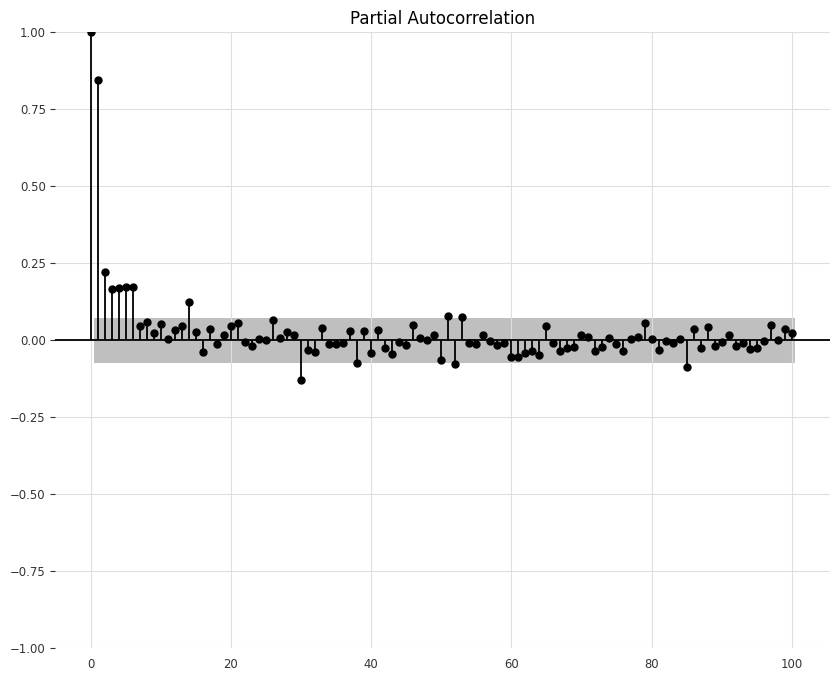

In [18]:
plt.rc("figure" ,figsize = (10,8))
plot_pacf(df['y'] , lags = 100)
plt.show()

# Data Preprocessing

In [19]:
df_future = df.iloc[-61:,:]
df = df.iloc[:-61 , ]

In [20]:
df.shape

(670, 10)

In [21]:
df_future.shape

(61, 10)

In [22]:
series = TimeSeries.from_series(df['y'])

In [23]:
train , val = series.split_after(pd.Timestamp("20120730")) 

In [24]:
scaler1 = Scaler()
train_transformed = scaler1.fit_transform(train)
val_transformed  = scaler1.transform(val)
series_transformed = scaler1.transform(series)

In [25]:
year_series = datetime_attribute_timeseries(
    pd.date_range(start = series.start_time(),
                 freq = series.freq_str,
                 periods = len(series)),
    attribute = "year",
    one_hot = False
)

year_series = Scaler().fit_transform(year_series)

month_series = datetime_attribute_timeseries(
    year_series,
    attribute = 'month',
    one_hot = True
)

weekday_series = datetime_attribute_timeseries(year_series,
                                             attribute = 'weekday',
                                             one_hot = True)

In [26]:
df.head()

,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,y
ds,,,,,,,,,,
2011-01-01,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
2011-01-02,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2011-01-03,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
2011-01-04,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
2011-01-05,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [27]:
# Covaraites
covariates_1 = TimeSeries.from_dataframe(df.iloc[:,0:9])
covariates_transformed = Scaler().fit_transform(covariates_1)

In [28]:
covariates_2 = year_series.stack(month_series).stack(weekday_series)

In [29]:
covariates_transformed = covariates_transformed.stack(covariates_2)

In [30]:
TimeSeries.to_dataframe(covariates_transformed)

component,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,year,...,month_9,month_10,month_11,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
ds,,,,,,,,,,,,,,,,,,,,,
2011-01-01,0.0,0.0,1.000000,0.0,0.5,0.355170,0.373517,0.828620,0.284606,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2011-01-02,0.0,0.0,0.000000,0.0,0.5,0.379232,0.360541,0.715771,0.466215,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2011-01-03,0.0,0.0,0.166667,1.0,0.0,0.171000,0.144830,0.449638,0.465740,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-04,0.0,0.0,0.333333,1.0,0.0,0.175530,0.174649,0.607131,0.284297,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2011-01-05,0.0,0.0,0.500000,1.0,0.0,0.209120,0.197158,0.449313,0.339143,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-10-27,1.0,0.0,1.000000,0.0,0.5,0.586727,0.572392,0.740360,0.439730,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2012-10-28,1.0,0.0,0.000000,0.0,0.5,0.521309,0.510223,0.714224,0.774353,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2012-10-29,1.0,0.0,0.166667,1.0,1.0,0.474582,0.472982,0.904884,0.692286,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# RNN Model

In [31]:
# RNNModel

model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    n_rnn_layers = 1,
    dropout=0.0,
    batch_size=30,
    n_epochs=50,
    optimizer_kwargs={"lr": 1e-3},
    random_state= 42,
    training_length=40,
    input_chunk_length= 20,
    save_checkpoints=True,
    pl_trainer_kwargs = {'accelerator' : 'gpu',
                            'devices' : 1,
                        'enable_progress_bar' : False}
)

/usr/local/lib/python3.11/dist-packages/torch/random.py:187: UserWarning: CUDA reports that you have 2 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of CUDAs. If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using. For example, if you are using CPU only, set device.upper()_VISIBLE_DEVICES= or devices=[]; if you are using device 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(message)


In [32]:
model.fit(
    train_transformed,
    future_covariates = covariates_transformed,
    val_series = val_transformed,
    val_future_covariates = covariates_transformed,
    verbose = False
)

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=1, dropout=0.0, training_length=40, batch_size=30, n_epochs=50, optimizer_kwargs={'lr': 0.001}, random_state=42, input_chunk_length=20, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': 1, 'enable_progress_bar': False})

In [33]:
pred_series = model.predict(n = len(val) ,
                           future_covariates = covariates_transformed,
                           verbose = False)

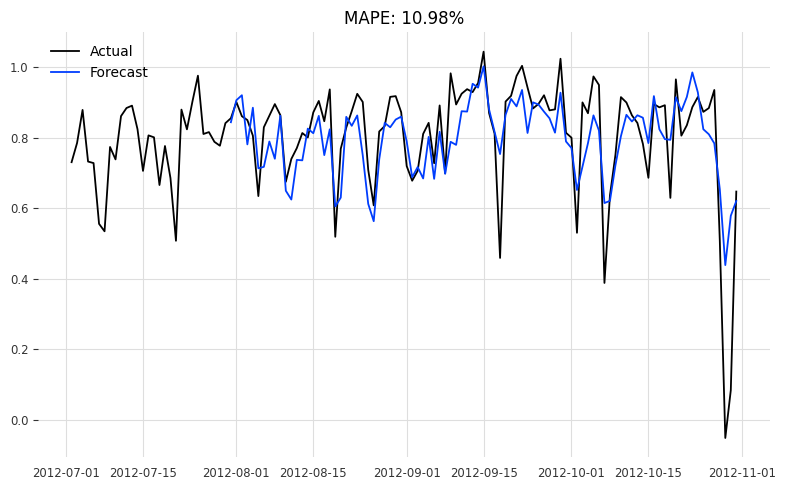

In [34]:
_ , series_transformed_slice = series_transformed.split_after(pd.Timestamp("20120701"))

plt.figure(figsize=(8, 5))

# Plot actual values
plt.plot(series_transformed_slice.time_index, series_transformed_slice.values(), label="Actual")

# Plot forecasted values
plt.plot(pred_series.time_index, pred_series.values(), label="Forecast")

# Add title with MAPE
plt.title(f"MAPE: {mape(pred_series, val_transformed):.2f}%")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Cross Validation

In [35]:
cv = model.historical_forecasts(series = series_transformed,
                               future_covariates = covariates_transformed,
                               start = df.shape[0] - 150,
                               forecast_horizon = len(val),
                               stride = 30,
                               retrain = True,
                               last_points_only = False,
                                verbose = False
                               )

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:384: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train_loss', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?


In [36]:
from sklearn.metrics import mean_absolute_percentage_error

mape_cv = []

for i in range(len(cv)):
    
    predictions = TimeSeries.to_series(scaler1.inverse_transform(cv[i]))
    
    start = predictions.index.min()
    end = predictions.index.max()
    actuals = df.y[start:end ,]
    
    error_cv = mean_absolute_percentage_error(actuals, predictions)
    mape_cv.append(error_cv)

print(np.mean(mape_cv))

0.12741302912881008


In [37]:
param_grid = {'n_rnn_layers' : [1],
             'hidden_dim' : [20],
             'dropout' : [0.0,],
             'n_epochs' : [50],
             'lr' : [0.003],
             'training_length' : [25,40],
             'input_chunk_length' : [15,20]
             }

grid = ParameterGrid(param_grid)
len(list(grid))

4

In [39]:
# Parameter Tuning Loop
from sklearn.metrics import mean_squared_error
rmse = []

for params in grid:

   # Build the model
    model = RNNModel(model = 'LSTM',
                    hidden_dim = params['hidden_dim'],
                    n_rnn_layers = params['n_rnn_layers'],
                    dropout = params['dropout'],
                    batch_size=30,
                    n_epochs = params['n_epochs'],
                    optimizer_kwargs = {'lr' : 0.003},
                    random_state = 42 ,
                    training_length = params['training_length'],
                    input_chunk_length = params['input_chunk_length'],
                    save_checkpoints=True,
                    pl_trainer_kwargs = {'accelerator' : 'gpu',
                                            'devices' : 1,
                                        'enable_progress_bar' : False}
                
                  )

    
    model.fit(series_transformed, 
              future_covariates= covariates_transformed,
             verbose = False)
    
    # Cross Validation with rollling window
    
    cv = model.historical_forecasts(series = series_transformed,
                                   future_covariates = covariates_transformed,
                                   start = df.shape[0] -180,
                                   forecast_horizon = len(val),
                                   stride = 30,
                                   retrain = True,
                                   verbose = False,
                                   last_points_only = False)

    rmse_cv = []
    
    for i in range(len(cv)):
    
        predictions = TimeSeries.to_series(scaler1.inverse_transform(cv[i]))

        # Actuals
        start = predictions.index.min()
        end = predictions.index.max()
        actuals = df.y[start:end , ]

        # Compute the error
        error_cv = np.sqrt(mean_squared_error(actuals , predictions))
        rmse_cv.append(error_cv)
        
  # Calculating and storing the error
    error = np.mean(rmse_cv)
    rmse.append(error)
        

In [40]:
print(np.mean(rmse))

1291.2288967274105


In [41]:
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
tuning_results

,dropout,hidden_dim,input_chunk_length,lr,n_epochs,n_rnn_layers,training_length,rmse
0,0.0,20,15,0.003,50,1,25,1199.773725
1,0.0,20,15,0.003,50,1,40,1376.627700
2,0.0,20,20,0.003,50,1,25,1205.893244
3,0.0,20,20,0.003,50,1,40,1382.620918


In [42]:
best_params = tuning_results[tuning_results['rmse'] == tuning_results['rmse'].min()]
best_params = best_params.iloc[0,:]
best_params.to_csv("best_params_round1.csv")

In [43]:
params_round1 = pd.read_csv("best_params_round1.csv", index_col = 0)
params_round1

,0
dropout,0.000000
hidden_dim,20.000000
input_chunk_length,15.000000
lr,0.003000
n_epochs,50.000000
n_rnn_layers,1.000000
training_length,25.000000
rmse,1199.773725


In [44]:
hidden_dim = int(params_round1.loc['hidden_dim'].iloc[0])
n_rnn_layers = int(params_round1.loc['n_rnn_layers'].iloc[0])
dropout = params_round1.loc['dropout'].iloc[0]
n_epochs = int(params_round1.loc['n_epochs'].iloc[0])
lr = params_round1.loc['lr'].iloc[0]
training_length = int(params_round1.loc['training_length'].iloc[0])
input_chunk_length = int(params_round1.loc['input_chunk_length'].iloc[0])

In [45]:
df_future.head()

,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,y
ds,,,,,,,,,,
2012-11-01,4,0,4,1,2,0.365833,0.369942,0.581667,0.157346,5986
2012-11-02,4,0,5,1,1,0.355000,0.356042,0.522083,0.266175,5847
2012-11-03,4,0,6,0,2,0.343333,0.323846,0.491250,0.270529,5138
2012-11-04,4,0,0,0,1,0.325833,0.329538,0.532917,0.179108,5107
2012-11-05,4,0,1,1,1,0.319167,0.308075,0.494167,0.236325,5259


# Predictions

In [46]:
X = pd.concat([df , df_future])

In [47]:
X.shape

(731, 10)

In [48]:
series = TimeSeries.from_series(X['y'])

In [49]:
train , val = series.split_after(pd.Timestamp("20121130"))

In [50]:
train_transformed = scaler1.fit_transform(train)
val_transformed  = scaler1.transform(val)
series_transformed = scaler1.transform(series)

In [51]:
# Year 
year_series = datetime_attribute_timeseries(
    pd.date_range(start = series.start_time(),
                 freq = series.freq_str,
                 periods = X.shape[0]),
    attribute = 'year',
    one_hot = False)

year_series = Scaler().fit_transform(year_series)
# Month
month_series = datetime_attribute_timeseries(year_series,
                                            attribute = 'month',
                                            one_hot = True)

# Weekday
weekday_series = datetime_attribute_timeseries(year_series,
                                            attribute = 'weekday',
                                            one_hot = True)

In [52]:
covariates_1 = TimeSeries.from_dataframe(X.iloc[:,0:9])
covariates_transformed = Scaler().fit_transform(covariates_1)

In [53]:
covariates_2 = year_series.stack(month_series).stack(weekday_series)

In [54]:
covariates_transformed = covariates_transformed.stack(covariates_2)

In [55]:
TimeSeries.to_dataframe(covariates_transformed)

component,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,year,...,month_9,month_10,month_11,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
ds,,,,,,,,,,,,,,,,,,,,,
2011-01-01,0.0,0.0,1.000000,0.0,0.5,0.355170,0.373517,0.828620,0.284606,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2011-01-02,0.0,0.0,0.000000,0.0,0.5,0.379232,0.360541,0.715771,0.466215,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2011-01-03,0.0,0.0,0.166667,1.0,0.0,0.171000,0.144830,0.449638,0.465740,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-04,0.0,0.0,0.333333,1.0,0.0,0.175530,0.174649,0.607131,0.284297,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2011-01-05,0.0,0.0,0.500000,1.0,0.0,0.209120,0.197158,0.449313,0.339143,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-27,0.0,0.0,0.666667,1.0,0.5,0.243025,0.193709,0.671380,0.675656,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-12-28,0.0,0.0,0.833333,1.0,0.5,0.241986,0.230993,0.606684,0.274350,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-12-29,0.0,0.0,1.000000,0.0,0.5,0.241986,0.214393,0.774208,0.210260,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [56]:
model = RNNModel(model = 'LSTM',
                hidden_dim = hidden_dim,
                n_rnn_layers = n_rnn_layers ,
                dropout = dropout,
                batch_size = 40,
                n_epochs = n_epochs,
                optimizer_kwargs = {'lr': lr},
                random_state = 42,
                training_length = training_length,
                input_chunk_length = input_chunk_length,
                save_checkpoints = True,
                pl_trainer_kwargs = {'accelerator' : 'gpu',
                                     'devices' : 1,
                                     'enable_progress_bar' : False}
               ) 



In [57]:
model.fit(train_transformed, 
          future_covariates = covariates_transformed,
         verbose = False)

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=1, dropout=0.0, training_length=25, batch_size=40, n_epochs=50, optimizer_kwargs={'lr': 0.003}, random_state=42, input_chunk_length=15, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': 1, 'enable_progress_bar': False})

In [58]:
pred_series = model.predict(n = len(val),
                           future_covariates = covariates_transformed,
                           verbose = False)


In [59]:
_ , series_transformed_slice = series_transformed.split_after(pd.Timestamp("20120801"))

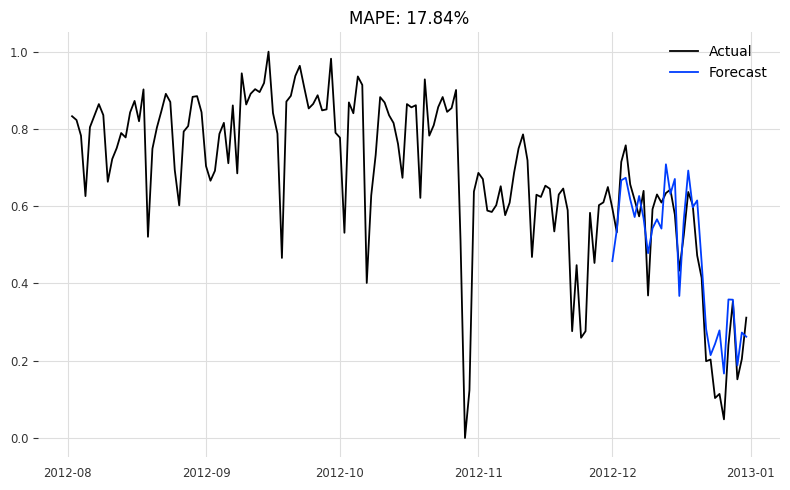

In [60]:
import matplotlib.pyplot as plt
from darts.metrics import mape

plt.figure(figsize=(8, 5))

# Plot actual values
plt.plot(series_transformed_slice.time_index, series_transformed_slice.values(), label="Actual")

# Plot forecasted values
plt.plot(pred_series.time_index, pred_series.values(), label="Forecast")

# Add title with MAPE
plt.title(f"MAPE: {mape(pred_series, val_transformed):.2f}%")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
